## Downstream Task: ImageWang

At the heart of this experiment we are trying to answer: 

> What is better: the best trained network starting with *random* weights, or the best trained network starting with weights generated from a *pretext* task?

This may seem obvious but it's important to keep in mind when designing our experiments. In order to train a network with random weights in the best possible way, we will use the approach that gives the highest accuracy when training from scratch on [Imagenette](https://github.com/fastai/imagenette/tree/58a63175a2c6457650289d32741940d6a7d58fbf).

To be honest, I'm not sure what the best possible way to train a network that has been initialized with pretext weights. Therefore we will try both training the only head of the network and training the entire network with discriminitive fine-tuning.

This gives us three scenarios we'd like to compare:

1. Training an entire model that is initialized with random weights.
2. Training the head of a model that is initialized with weights generated on a pretext task.
3. Training an entire model that is initialized with weights generated on a pretext task.


For our experiments here we'll continue using the [ImageWang](https://github.com/fastai/imagenette/blob/master/README.md) dataset. It contains a curated subset of images from the original Imagenet dataset.

It contains:

- A `/train` folder with 20 classes
- A `/val` folder with 10 classes (all of which are in /train)
- An `/unsup` folder with miscellaneous unlabelled images

In [14]:
import json
import torch
import numpy as np

from config import config
from RandomCutout import RandomCutout, PILImageInput

from fastai2.basics import *
from fastai2.vision.all import *

from torch.nn import MSELoss
from functools import partial

## Random Weights Baseline

Let's train a completely random network in the best way we know how. The [Imagenette Leaderboard](https://github.com/fastai/imagenette/) contains hyperparameters that give the highest accuracy when trained on the Imagenette dataset (a subset of Imagenet). 

We will use all the tips and tricks from [training Imagenette](https://github.com/fastai/imagenette/tree/58a63175a2c6457650289d32741940d6a7d58fbf).

In [15]:
# Default parameters
lr=config['lr']
size=config['size']
sqrmom=config['sqrmom']
mom=config['mom']
eps=config['eps']
epochs=config['epochs']
bs=config['bs']
mixup=config['mixup']
opt=config['opt']
sh=config['sh']
sa=config['sa']
sym=config['sym']
beta=config['beta']
act_fn=config['act_fn']
fp16=config['fp16']
pool=config['pool']
dump=config['dump']
runs=config['runs']

model = config['model']


if   opt=='adam'  : opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
elif opt=='rms'   : opt_func = partial(RMSProp, sqr_mom=sqrmom)
elif opt=='sgd'   : opt_func = partial(SGD, mom=mom)
elif opt=='ranger': opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

runs = 3

In [17]:
# Default parameters
print("lr", lr)
print("size", size)
print("sqrmom", sqrmom)
print("mom", mom)
print("eps", eps)
print("epochs", epochs)
print("bs", bs)
print("mixup", mixup)
print("opt", opt)
print("sh", sh)
print("sa", sa)
print("sym", sym)
print("beta", beta)
print("act_fn", act_fn)
print("fp16", fp16)
print("pool", pool)
print("runs", runs)
print("model", model)

lr 0.008
size 128
sqrmom 0.99
mom 0.9
eps 1e-06
epochs 15
bs 64
mixup 0.0
opt ranger
sh 0.0
sa 0
sym 0
beta 0.0
act_fn <class 'fastai2.layers.Mish'>
fp16 0
pool <function MaxPool at 0x7f1691297ef0>
runs 3
model <function xresnet34 at 0x7f16910a6950>


In [18]:
def get_dbunch(size, bs):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    
    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    batch_tfms=RandomErasing(p=0.9, max_count=3, sh=sh) 
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files,
                       get_y=parent_label,
                       item_tfms=item_tfms,
                       batch_tfms=batch_tfms)
    
    workers = min(8, num_cpus())
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=workers)

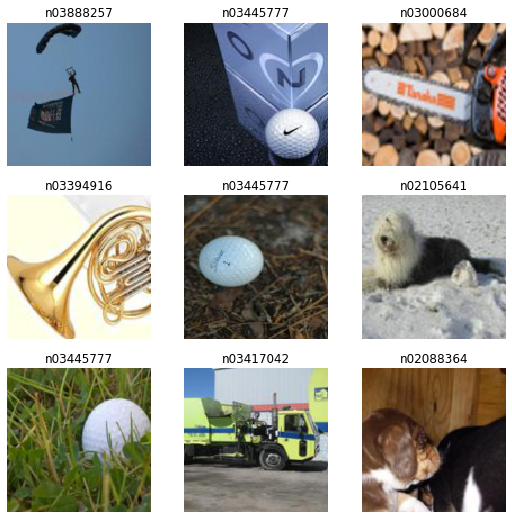

In [19]:
size = 128
bs = 64

dbunch = get_dbunch(size, bs)
dbunch.show_batch()

In [7]:
for run in range(runs):
        print(f'Run: {run}')
        learn = Learner(dbunch, model(c_out=20, act_cls=act_fn, sa=sa, sym=sym, pool=pool, pretrained=False), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
        if dump: print(learn.model); exit()
        if fp16: 
            learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        #n_gpu = torch.cuda.device_count()
        #if gpu is None and n_gpu: learn.to_parallel()
        if num_distrib()>1: learn.to_distributed(gpu) # Requires `-m fastai.launch`
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.722770,3.407506,0.062866,0.413591,00:20
1,1.531323,3.242239,0.071519,0.456605,00:19
2,1.397891,2.678288,0.210232,0.685162,00:20
3,1.291472,3.049402,0.142275,0.571138,00:21
4,1.264792,2.834366,0.195979,0.691779,00:20
5,1.185334,2.436970,0.302367,0.759226,00:20
6,1.156195,2.417446,0.305167,0.768643,00:19
7,1.128688,2.419268,0.320438,0.752863,00:20
8,1.070506,2.431067,0.314329,0.827437,00:19
9,1.068943,3.174528,0.171036,0.574192,00:20


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.743210,3.242778,0.034614,0.464749,00:20
1,1.510517,2.882794,0.115806,0.639857,00:19
2,1.384762,3.280335,0.057012,0.483329,00:20
3,1.321688,3.083504,0.116315,0.622041,00:20
4,1.248295,2.738608,0.183507,0.623314,00:20
5,1.199936,2.530824,0.249427,0.752609,00:20
6,1.170637,2.297239,0.321456,0.801476,00:20
7,1.121350,2.931457,0.201323,0.622805,00:21
8,1.115283,2.606536,0.255027,0.692034,00:21
9,1.060828,2.334816,0.343344,0.777297,00:20


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.727160,3.309998,0.035632,0.403411,00:20
1,1.525567,3.758032,0.032833,0.388139,00:20
2,1.387224,3.289460,0.100534,0.507254,00:20
3,1.326017,3.381019,0.051922,0.509290,00:20
4,1.255422,3.244345,0.107406,0.552303,00:20
5,1.201757,2.310376,0.334945,0.805294,00:20
6,1.163191,2.223674,0.362688,0.819038,00:21
7,1.104691,2.227056,0.386867,0.803767,00:21
8,1.071625,2.621057,0.279969,0.785951,00:20
9,1.054599,2.503656,0.320183,0.745228,00:20


When I run the above for 3 runs I get:

- Run 1: 0.541105
- Run 2: 0.546449
- Run 3: 0.541614

This gives us a random weights baseline accuracy of **54.3%**.

## Pretext Weights: Frozen Network 

Now that we've got a random weights baseline, we'd like to see whether training a network starting with pretext weights gives us any improvement. For this experiment we will exclusively train the head of our network for `100` epochs.

In [9]:
for run in range(runs):
        print(f'Run: {run}')
        learn = Learner(dbunch, model(c_out=20, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool, pretrained=False), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
            
        # Load weights generated from training on our pretext task
        state_dict = torch.load('imagewang_inpainting_15_epochs.pth')
        # HACK: If we don't have all of the parameters for our learner, we get an error
        linear_layer = learn.model[-1]
        state_dict['11.weight'] = linear_layer.weight
        state_dict['11.bias'] = linear_layer.bias
        
        learn.model.load_state_dict(state_dict)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.637447,3.426521,0.021125,0.403411,00:19
1,1.452847,2.818143,0.142784,0.599898,00:21
2,1.343899,3.634332,0.070501,0.483075,00:22
3,1.253317,3.316341,0.098244,0.635276,00:21
4,1.209438,3.068367,0.136167,0.569611,00:21
5,1.150593,2.449127,0.301858,0.753627,00:22
6,1.117368,2.351655,0.322219,0.807839,00:23
7,1.081421,2.604428,0.259863,0.719522,00:22
8,1.052427,2.469481,0.320438,0.792568,00:23
9,1.027207,2.123329,0.418427,0.826419,00:23


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.644566,3.007755,0.061848,0.560957,00:22
1,1.451364,3.978268,0.006363,0.428353,00:21
2,1.331235,2.570281,0.207686,0.688725,00:22
3,1.270840,2.953739,0.151693,0.673963,00:22
4,1.203200,3.444169,0.067447,0.432680,00:22
5,1.167521,2.310376,0.337999,0.803258,00:20
6,1.098867,2.516770,0.257317,0.747009,00:21
7,1.107796,2.291883,0.343599,0.813439,00:20
8,1.048216,2.391764,0.329346,0.770425,00:21
9,1.037951,2.473650,0.316111,0.815220,00:20


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.638341,3.321979,0.044286,0.426572,00:21
1,1.434669,3.596668,0.038432,0.333164,00:20
2,1.330588,2.741370,0.176635,0.729957,00:21
3,1.277497,3.905372,0.014762,0.491983,00:20
4,1.199176,2.985345,0.149147,0.598117,00:21
5,1.166015,2.625504,0.249936,0.724103,00:21
6,1.118635,2.273333,0.347671,0.819292,00:21
7,1.083484,2.561490,0.266480,0.751591,00:20
8,1.047927,2.495946,0.327055,0.762280,00:20
9,1.028191,2.514100,0.313820,0.741156,00:20


When I run the above for 3 runs I get:

- Run 1: 0.563502
- Run 2: 0.554849
- Run 3: 0.546449

This gives us an average accuracy of **55.5%**

## Pretext Weights: Frozen Network + Discriminitive Learning

We've already beaten the network initialized with random weights, but it seems unlikely that fine-tuning the head of a network initialized with pretext weights is the best way to train.

In this experiment we initialize our network using the weights generated by pretraining our network on a pretext task. We will train the head of our network for `5` epochs and then use discriminitive learning rates to train the rest of the network for `95` epochs.

When we fine-tune we will use a slice from `lr//100` to `lr`. This is taken from fastai's [`.fine_tune()`](https://github.com/fastai/fastai2/blob/c942b186b032dcb4d42c95f56893957a24a4f96d/fastai2/callback/schedule.py#L130).

**Some concerns**:
- I am essentially trying to mix "the best way to train with random weights" with "the best way to train with ImageNet weights". Can these approaches be mixed? I feel like I lack a necessary understanding of all the moving parts to say how they will behave once I combine them.
- I am using `fit_flat_cos()` because I'm using the `ranger` optimizer which reduces the need for learning rate warmup. I have not seen any examples of fine-tuning with this approach.
- I am not setting `pct_start`. Most examples I've seen set this. (They also use `.fit_one_cycle()`)

In [11]:
for run in range(runs):
        print(f'Run: {run}')
        learn = Learner(dbunch, model(c_out=20, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())

        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
            
        # Train 15 epochs w/ frozen head
        state_dict = torch.load('imagewang_inpainting_15_epochs.pth')

        # HACK: If we don't have all of the parameters for our learner, we get an error
        linear_layer = learn.model[-1]
        state_dict['11.weight'] = linear_layer.weight
        state_dict['11.bias'] = linear_layer.bias
        
        learn.model.load_state_dict(state_dict)
        
        # One epoch of fine-tuning
        learn.freeze()
        learn.fit_flat_cos(5, lr, wd=1e-2, cbs=cbs)
        # Remainder is train_imagenette.py approach, but with discriminitive learning rates
        learn.unfreeze()
        learn.fit_flat_cos(epochs - 5, slice(lr//100, lr), wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.610934,3.103520,0.057012,0.545686,00:19
1,1.455435,3.185627,0.069992,0.483075,00:20
2,1.343436,2.982459,0.135658,0.564011,00:20
3,1.253956,2.679826,0.205396,0.727157,00:20
4,1.091915,2.265352,0.352252,0.812930,00:20


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.140525,2.484067,0.278442,0.756427,00:20
1,1.129077,2.337972,0.328328,0.802749,00:20
2,1.112069,2.416078,0.294477,0.791550,00:20
3,1.093870,2.720676,0.249427,0.679308,00:20
4,1.045629,2.276946,0.357852,0.803767,00:20
5,1.024915,2.139431,0.425045,0.839399,00:21
6,1.001782,2.154728,0.409773,0.847798,00:20
7,0.977974,2.256172,0.387630,0.813184,00:20
8,0.882335,1.945984,0.517434,0.871214,00:20
9,0.815879,1.797805,0.554085,0.899211,00:20


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.645220,3.135375,0.070247,0.542377,00:21
1,1.458397,3.271493,0.089336,0.429880,00:20
2,1.332934,3.061048,0.140494,0.552303,00:21
3,1.274044,2.659435,0.220412,0.717994,00:21
4,1.088925,2.231138,0.355307,0.829473,00:21


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.149087,2.608109,0.252482,0.728684,00:20
1,1.139316,2.444611,0.277679,0.765589,00:20
2,1.105817,2.450424,0.306185,0.762535,00:20
3,1.082692,2.410487,0.294477,0.789768,00:20
4,1.063311,2.910844,0.228811,0.660982,00:21
5,1.029626,2.201466,0.393993,0.805294,00:21
6,1.004569,2.134251,0.409773,0.837618,00:21
7,0.982530,2.331706,0.370832,0.833545,00:20
8,0.907067,1.957600,0.501400,0.874523,00:21
9,0.823297,1.804676,0.549504,0.902011,00:20


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.633497,2.983353,0.108170,0.583355,00:20
1,1.441607,3.151756,0.103843,0.464240,00:21
2,1.332781,3.532391,0.026724,0.372105,00:21
3,1.257445,3.739145,0.043013,0.344362,00:21
4,1.086351,2.234843,0.359634,0.825146,00:20


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.145623,2.346003,0.317638,0.808857,00:21
1,1.140180,2.250086,0.351489,0.812930,00:20
2,1.107085,2.371602,0.351234,0.775515,00:22
3,1.094277,2.681324,0.292186,0.723339,00:21
4,1.048361,2.666794,0.265207,0.683635,00:21
5,1.027960,2.320760,0.352762,0.790023,00:21
6,0.996275,2.200014,0.419954,0.836854,00:21
7,0.962873,2.194411,0.406465,0.827182,00:22
8,0.900310,2.016410,0.485365,0.868160,00:21
9,0.818345,1.762424,0.561721,0.898956,00:21


When I run the above for 3 runs I get:

- Run 1: 0.554085
- Run 2: 0.549504
- Run 3: 0.561721

This gives us an average accuracy of **55.5%** (the exact same as before).

## Conclusion

Our three experiments give us:

1. Random weights baseline: `54.3%` accuracy
2. Pretext weights with head fine-tuning: `55.5%` accuracy
3. Pretext weights with head fine-tuning followed by discriminitive learning: `55.5%` accuracy

In summary, we've demonstrated that we can get a reliable improvements in downstream accuracy by pre-training a network on a self-supervised pretext task. This is not super exciting in and of itself, but it gives us a good starting point from which to move towards more interesting questions.

Here are some questions we should consider investigating in future notebooks:

- Can we train on pretext for longer and see larger improvements in downstream performance?
- Are 100 epochs of downstream training enough?
- Can we train on multiple pretext tasks and see greater improvements?
- Can we ever hope to compete with pre-trained weights generated from labelled datasets (eg. Imagenet)?
  - What about domains where those pre-trained weights are weaker (eg. medical images)?